### Predict Type 2 diabetes with genomics data
by SVM, RandomForest, XGB, Keras and model ensemble

In [27]:
# this is an early version of sklearn, some names may have changed in later versions
# updated in pipeline.ipynb, improved accuracy by normalization with StandardScaler
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn import cross_validation as cv
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from xgboost.sklearn import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 

In [2]:
### Read in data
df = pd.read_csv('../data/top500pcaGene.csv')

In [4]:
df.head(3)

,t2d,5260,100873336,4555,1487,2641,4571,4519,11067,4577,...,93986,55089,26118,7072,837,286257,92255,1452,4832,10171
0,0,0.000000,0.000000,0.000000,3.322937,10.815594,4.808866,7.037647,0.0,4.109481,...,0.0,5.075939,4.855219,1.789240,0.0,0.0,4.891742,5.580920,2.386135,0.000000
1,0,0.000000,3.400627,0.000000,2.284452,11.641512,5.379671,7.540405,0.0,5.365140,...,0.0,2.405160,3.903509,3.277050,0.0,0.0,0.000000,4.254837,0.000000,5.214127
2,0,3.492573,2.642864,4.768249,2.348791,10.814974,5.679429,8.156457,0.0,4.753775,...,0.0,4.323108,4.587719,3.748767,0.0,0.0,0.000000,5.637185,1.899896,1.480695


In [7]:
y = df['t2d'].values
X = df.drop(['t2d'], axis=1)

In [ ]:
### Split train, test
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size = 0.2, random_state=0)

### SVM

In [8]:
# Use GridSearchCV to find the best values for C and gamma
C_range = 10.0 ** np.arange(-4, 4)
gamma_range = 10.0 ** np.arange(-10, 1)
param_grid = dict(gamma=gamma_range, C=C_range)
skf = cv.StratifiedKFold(y=y_train, n_folds=3)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf)
grid.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 ..., 1 1], n_folds=3, shuffle=False, random_state=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00]), 'C': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [9]:
# Print out parameters
clf_svm = svm.SVC(probability=True, **grid.best_params_)
y_pred = clf_svm.fit(X_train, y_train).predict(X_test)
print (clf_svm)
print ("Best parameter", grid.best_params_ )
print ("Cross-Validation score", cv.cross_val_score(clf_svm, X_train,y_train, cv=5).mean())
print ("Independent accuracy score", accuracy_score(y_test, y_pred))
print ("Independent precision score", precision_score(y_test, y_pred))
print ("Independent recall score", recall_score(y_test, y_pred))
print ("Independent f1 score", f1_score(y_test, y_pred))

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best parameter {'gamma': 0.001, 'C': 10.0}
Cross-Validation score 0.828102126176
Independent accuracy score 0.815789473684
Independent precision score 0.836206896552
Independent recall score 0.858407079646
Independent f1 score 0.847161572052


In [10]:
print(cv.cross_val_score(clf_svm, X_train, y_train, cv=5).mean())

0.828102126176


In [13]:
## Plot ROC curve
# Compute roc and auc
probas_ = clf_svm.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr) 

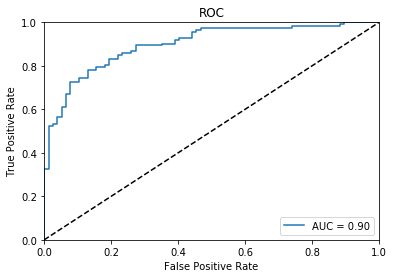

In [14]:
# Confusion Matrix
y_pred = clf_svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Random Forest

In [12]:
#max_features = 23, sqrt(500)
clf_rf = RandomForestClassifier(n_estimators=1000, max_features=23)
clf_rf = clf_rf.fit(X_train, y_train)
print(cv.cross_val_score(clf_rf, X_train, y_train, cv=5).mean())

0.8769954688044616


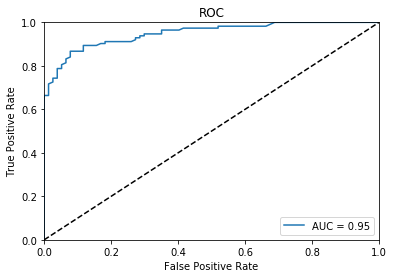

In [17]:
# Plot ROC curve
# Compute roc and auc
probas_ = clf_rf.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Get important features
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

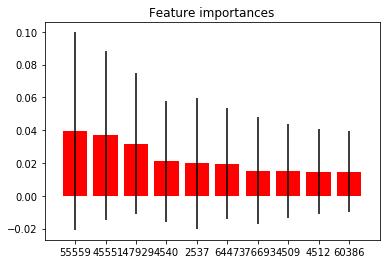

In [52]:
# Print the feature ranking
# Plot the feature importances, x axis= Entrez gene ID
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices][:10],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(10), df.columns.values[indices[:10]])
plt.xlim([-1, 10])
plt.show()

In [57]:
# save feature genes
top50 = pd.DataFrame(df.columns.values[indices[:100]])
top50.to_csv('../results/RF_importance100.csv', index=False, header=False)

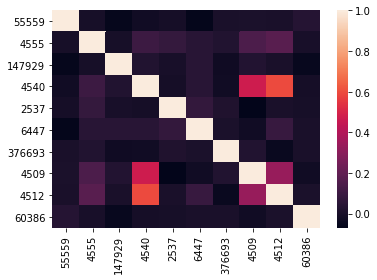

In [90]:
# gene-gene correlation 
sns.heatmap(df[df.columns.values[indices[:10]]].corr())

### xgb

In [21]:
clf_xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,  
                    subsample=0.5, colsample_bytree=0.5, seed=0)                  
clf_xgb = clf_xgb.fit(X_train, y_train)
print(cv.cross_val_score(clf_xgb, X_train, y_train, cv=5).mean())
print(cv.cross_val_score(clf_xgb, X_train, y_train, cv=5))

0.886258278146
[ 0.875       0.85430464  0.90066225  0.91390728  0.88741722]


In [92]:
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier


clf_xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,  
                    subsample=0.5, colsample_bytree=0.5, seed=0)                  
clf_xgb = clf_xgb.fit(X_train, y_train)
print(cross_val_score(clf_xgb, X_train, y_train, cv=5).mean())
print(cross_val_score(clf_xgb, X_train, y_train, cv=5))

0.8862582781456954
[0.875      0.85430464 0.90066225 0.91390728 0.88741722]


In [93]:
probas_ = clf_xgb.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

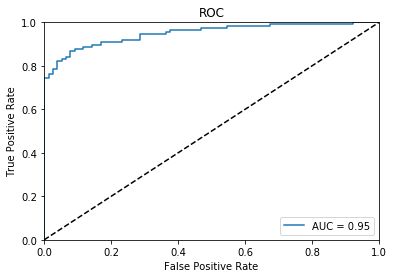

In [22]:
# Plot ROC curve
# Compute roc and auc
probas_ = clf_xgb.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [108]:
# OR interactive RUC with bokeh
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.io import output_notebook

# output_file("ruc.html")
source = ColumnDataSource(data=dict(
    x=fpr,
    y=tpr,    
))
TOOLTIPS = [
    ("(x,y)", "($x, $y)"),    
]

output_notebook()
p = figure(plot_width=600, plot_height=400, tooltips=TOOLTIPS,)
p.line('x', 'y', line_width=2, source=source)
show(p)

Loading BokehJS ...

### model ensemble

In [23]:
from sklearn.ensemble import VotingClassifier

In [24]:
clf_vote = VotingClassifier(
    estimators=[
        ('svm', clf_svm),
        ('xgb', clf_xgb),
        ('RF', clf_rf),
        ],
    weights=[2,4,3],
    voting='soft')
clf_vote.fit(X_train,y_train)
print(cv.cross_val_score(clf_vote, X_train, y_train, cv=5).mean())
print(cv.cross_val_score(clf_vote, X_train, y_train, cv=5))

0.888915998606
[ 0.86842105  0.87417219  0.9205298   0.90066225  0.88741722]


In [25]:
print(cv.cross_val_score(clf_vote, X_train, y_train, cv=5, scoring= 'accuracy').mean())

0.890240501917


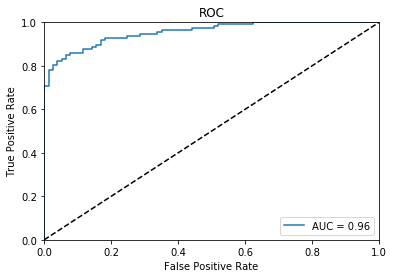

In [26]:
# Plot ROC curve
# Compute roc and auc
probas_ = clf_vote.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### CNN

In [1]:
### keras
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [29]:
nb_epoch = 300 
batch_size = 32

In [30]:
arrayTrainFeatures = np.array(X_train)
arrayTrainLabels = np.array(y_train)
arrayTestFeatures = np.array(X_test)

In [31]:
model = Sequential()
model.add(Dense(1, input_dim=500, activation='sigmoid'))
model.add(Dropout(0.2)) # prevent overfitting
model.add(Dense(1, input_dim=50, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 501       
_________________________________________________________________
dropout_5 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 503
Trainable params: 503
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(arrayTrainFeatures, arrayTrainLabels,
              validation_split=0.2,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              shuffle=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 604 samples, validate on 152 samples
Epoch 1/300
604/604 [==============================] - 0s 659us/step - loss: 0.6813 - acc: 0.6060 - val_loss: 0.6842 - val_acc: 0.5789
Epoch 2/300
604/604 [==============================] - 0s 74us/step - loss: 0.6722 - acc: 0.6093 - val_loss: 0.6809 - val_acc: 0.5789
Epoch 3/300
604/604 [==============================] - 0s 112us/step - loss: 0.6670 - acc: 0.6093 - val_loss: 0.6758 - val_acc: 0.5789
Epoch 4/300
604/604 [==============================] - 0s 85us/step - loss: 0.6619 - acc: 0.6093 - val_loss: 0.6719 - val_acc: 0.5789
Epoch 5/300
604/604 [==============================] - 0s 75us/step - loss: 0.6489 - acc: 0.6093 - val_loss: 0.6666 - val_acc: 0.5789
Epoch 6/300
604/604 [==============================] - 0s 86us/step - loss: 0.6475 - acc: 0.6093 - val_loss: 0.6631 - val_acc: 0.5789
Epoch 7/300
604/604 [==============================] - 0s 83us/step - loss: 0.6326 - acc: 0.6093 - val_loss: 0.6639 - val_acc: 0.5789
Epoch 8/300
60

604/604 [==============================] - 0s 78us/step - loss: 0.3686 - acc: 0.8560 - val_loss: 0.5467 - val_acc: 0.7500
Epoch 122/300
604/604 [==============================] - 0s 74us/step - loss: 0.3494 - acc: 0.8775 - val_loss: 0.5551 - val_acc: 0.7368
Epoch 123/300
604/604 [==============================] - 0s 79us/step - loss: 0.3511 - acc: 0.8725 - val_loss: 0.5412 - val_acc: 0.7500
Epoch 124/300
604/604 [==============================] - 0s 77us/step - loss: 0.3515 - acc: 0.8725 - val_loss: 0.5430 - val_acc: 0.7566
Epoch 125/300
604/604 [==============================] - 0s 81us/step - loss: 0.3646 - acc: 0.8593 - val_loss: 0.5421 - val_acc: 0.7566
Epoch 126/300
604/604 [==============================] - 0s 75us/step - loss: 0.3449 - acc: 0.8791 - val_loss: 0.5460 - val_acc: 0.7566
Epoch 127/300
604/604 [==============================] - 0s 80us/step - loss: 0.3746 - acc: 0.8460 - val_loss: 0.5467 - val_acc: 0.7566
Epoch 128/300
604/604 [==============================] - 0s 76

604/604 [==============================] - 0s 89us/step - loss: 0.2665 - acc: 0.8940 - val_loss: 0.5979 - val_acc: 0.7500
Epoch 242/300
604/604 [==============================] - 0s 84us/step - loss: 0.2642 - acc: 0.8957 - val_loss: 0.6107 - val_acc: 0.7434
Epoch 243/300
604/604 [==============================] - 0s 81us/step - loss: 0.2817 - acc: 0.8825 - val_loss: 0.5889 - val_acc: 0.7500
Epoch 244/300
604/604 [==============================] - 0s 87us/step - loss: 0.3059 - acc: 0.8642 - val_loss: 0.6045 - val_acc: 0.7500
Epoch 245/300
604/604 [==============================] - 0s 85us/step - loss: 0.2658 - acc: 0.8940 - val_loss: 0.6167 - val_acc: 0.7434
Epoch 246/300
604/604 [==============================] - 0s 80us/step - loss: 0.2967 - acc: 0.8709 - val_loss: 0.5873 - val_acc: 0.7566
Epoch 247/300
604/604 [==============================] - 0s 80us/step - loss: 0.2812 - acc: 0.8825 - val_loss: 0.5884 - val_acc: 0.7566
Epoch 248/300
604/604 [==============================] - 0s 76

In [86]:
cnnPred = np.round(cnnModel.predict(arrayTestFeatures))

### Conclusion
1. models reached average cross validation accuracy of 0.88 and AUC > 0.95, which is not bad for biological data with limited samples
2. diverse model ensemble with diverse models only slightly improved accuracy, perhaps because different models all picked same strong predictors hence adding different modele together did not improve performance
3. neural network is not a best perfomer in this case, perhaps more training data are needed